# Projet: Prédiction de prix de l'électricité

## Auteur: Paul COFFI

### **Contexte**

Dans le cadre de l’activité de valorisation de l’énergie sur les marchés de l’électricité, Elmy aimerait disposer d’un modèle de prévision permettant de juger en amont si les prix de l’électricité sur le marché SPOT (marché d’enchère européen permettant d’acheter de l’électricité la veille pour le lendemain) seront plus ou moins élevés que les prix de l’électricité sur le marché Intraday (marché boursier européen permettant d’acheter de l’électricité le jour même).

### **But**

L’exercice consiste en la modélisation supervisée de l'écart de prix entre le marché infra-journalier (dit "Intraday") et le marché SPOT. L'écart de prix peut être modélisé par une régression mais aussi par une classification car ce qui importe avant tout est de prédire correctement le sens de cet écart (si tel ou tel prix sera supérieur ou inférieur à l’autre).

### **Description des données**

Index
DELIVERY_START : date et heure de livraison de l'électricité

Variables explicatives
load_forecast : prévision de consommation totale d'éléctricité en France
coal_power_available, gas_power_available, nucelear_power_available : capacité de production totale d'électricité des centrales à charbon, gaz et nucléaire respectivement,
wind_power_forecasts_average, solar_power_forecasts_average : moyenne de différentes prévisions de production totale d'électricité éolienne et solaire (respectivement),
wind_power_forecasts_std, solar_power_forecasts_std : écart-type de ces mêmes prévisions,
predicted_spot_price : prévision du prix SPOT de l'électricité issues d'un modèle interne de Elmy. Ce modèle est lancé chaque jour avant la fermeture des enchères SPOT pour le lendemain.

Variable cible
spot_id_delta : l'écart entre le VWAP des transactions sur le marché infra-journalier (Intraday) et le prix SPOT pour 1MWh d'électricité (spot_id_delta = Intraday - SPOT) : si la valeur est positive, le prix Intraday est supérieur au prix SPOT et inversement.

On va introduire deux nouvelles d'intération entre les variables wind_power_forecasts_average et wind_power_forecasts_std d'une part, et les variables solar_powar_forecasts_average et solar_powar_forecasts_std d'autre part.

Typiquement cette valeur devrait etre proche de 0 dans le cas où l'incertitude des prédictions est moindre.

## 1. Analyse exploratoire et préparation des données

---------------Description du boosting blablabla----------------------

### 1.1 Analyse exploratoire

In [51]:
import numpy as np
import pandas as pd

In [11]:
import os
print(os.getcwd())


/home/paul


In [53]:
X= pd.read_csv('/home/paul/Downloads/X_train.csv')
y= pd.read_csv('/home/paul/Downloads/y_train.csv')

X['interaction 1']= X['wind_power_forecasts_average']*X['wind_power_forecasts_std']
X['interaction 2']= X['solar_power_forecasts_average']*X['solar_power_forecasts_std']

**Apercu de X**

In [14]:
print(X.head(5))

              DELIVERY_START  load_forecast  coal_power_available  \
0  2022-01-01 02:00:00+01:00        49439.0                3386.0   
1  2022-01-01 03:00:00+01:00        46511.0                3386.0   
2  2022-01-01 04:00:00+01:00        45158.0                3386.0   
3  2022-01-01 05:00:00+01:00        44779.0                3386.0   
4  2022-01-01 06:00:00+01:00        45284.0                3386.0   

   gas_power_available  nucelear_power_available  \
0              11487.0                   44118.0   
1              11487.0                   44118.0   
2              11487.0                   44118.0   
3              11487.0                   44118.0   
4              11487.0                   44118.0   

   wind_power_forecasts_average  solar_power_forecasts_average  \
0                        3035.0                            0.0   
1                        3143.0                            0.0   
2                        3288.0                            0.0   
3       

In [15]:
print(y.head(5))

              DELIVERY_START  spot_id_delta
0  2022-01-01 02:00:00+01:00     -36.874770
1  2022-01-01 03:00:00+01:00     -12.643588
2  2022-01-01 04:00:00+01:00      -1.950193
3  2022-01-01 05:00:00+01:00       1.938272
4  2022-01-01 06:00:00+01:00       0.199907


**Statistique de X**

In [17]:
X.describe()

,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price,interaction 1,interaction 2
count,9318.000000,10604.000000,10604.000000,10604.000000,10581.000000,10581.000000,10581.000000,10581.000000,1846.000000,1.058100e+04,1.058100e+04
mean,53725.132968,2819.781592,11463.220671,35393.282252,4512.989415,1919.281353,125.399422,24.997384,140.256024,7.187162e+05,1.215796e+05
std,11274.194929,495.103588,483.799154,7619.820162,3349.419356,2706.963383,132.152875,43.083977,33.922669,1.216081e+06,2.550346e+05
min,30515.000000,1646.000000,9769.000000,22285.000000,592.000000,0.000000,1.830211,0.000000,42.420000,1.385470e+03,0.000000e+00
25%,45336.500000,2226.000000,11140.000000,29005.000000,2036.000000,0.000000,46.818974,0.000000,119.405000,1.175034e+05,0.000000e+00
50%,51846.000000,2806.000000,11487.000000,32470.000000,3319.000000,149.000000,86.700163,3.507229,140.040000,3.119216e+05,5.346797e+02
75%,62091.750000,3386.000000,11945.000000,43055.000000,5951.000000,3507.000000,155.325644,35.137019,160.765000,7.868249e+05,1.335936e+05
max,85145.000000,3391.000000,11963.000000,50122.000000,15167.000000,10127.000000,1871.571992,745.261316,254.190000,2.093560e+07,4.499143e+06


**Statistique de y**

In [ ]:
y.describe()

In [ ]:
**Données manquantes**

In [ ]:
X.isnull().sum()/len(X)

On remarque que la variable **predicted_spot_price** a énormément de valeurs manquantes, de ce fait une simple imputation ne sera pas pertinente.

Dans la suite, une analyse des corrélations linéaires entre les différentes variables explicatives nous montrera qu'il existe une forte corrélation entre la variable **predicted_spot_price** et la variable **load_forecast** et une corrélation modérée entre la variable **predicted_spot_price** et **la variable nucelear_power_available** : L'imputation des valeurs manquantes se fera donc par une simple régression entre la variable **load_forecast** qui contient 12% de valeurs manquantes, la variable **predicted_spot_price** et la variable **nucelear_power_available**.

La variable **load_forecast** étant aussi fortement corrélée à la variable **nucelear_power_available** et modéremment corrélée aux variables **coal_power_available** et **gas_power_available**, l'imputation des valeurs manquantes se fera par une régression avec toutes les autres variables du modèle.

Le reste des valeurs manquantes sera imputée en remplacée par la médiane.

**Coefficient de corrélation**

In [55]:
X['DELIVERY_START']= pd.to_datetime(X['DELIVERY_START'], utc= True) ## On transforme la colonne delivery_start en une variable temporelle

In [57]:
X.corr()

,DELIVERY_START,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price,interaction 1,interaction 2
DELIVERY_START,1.000000,-0.073289,0.119729,0.346905,-0.013171,0.192387,-0.044751,0.088182,-0.015748,-0.246208,0.137580,-0.020906
load_forecast,-0.073289,1.000000,0.592586,0.487420,0.790554,0.056690,-0.002045,0.007775,0.028725,0.848274,0.035672,-0.016672
coal_power_available,0.119729,0.592586,1.000000,0.675499,0.773393,0.314780,-0.195945,0.110731,-0.058685,-0.136735,0.180282,-0.110604
gas_power_available,0.346905,0.487420,0.675499,1.000000,0.608884,0.374664,-0.220792,0.151959,-0.081660,0.129213,0.232216,-0.142336
nucelear_power_available,-0.013171,0.790554,0.773393,0.608884,1.000000,0.293377,-0.227825,0.090656,-0.110182,0.306091,0.161656,-0.163918
wind_power_forecasts_average,0.192387,0.056690,0.314780,0.374664,0.293377,1.000000,-0.207682,0.345215,-0.099868,-0.399666,0.565824,-0.141941
solar_power_forecasts_average,-0.044751,-0.002045,-0.195945,-0.220792,-0.227825,-0.207682,1.000000,-0.110381,0.631155,-0.034166,-0.122702,0.712238
wind_power_forecasts_std,0.088182,0.007775,0.110731,0.151959,0.090656,0.345215,-0.110381,1.000000,0.011466,0.018240,0.896010,-0.036585
solar_power_forecasts_std,-0.015748,0.028725,-0.058685,-0.081660,-0.110182,-0.099868,0.631155,0.011466,1.000000,-0.047489,-0.020849,0.926316
predicted_spot_price,-0.246208,0.848274,-0.136735,0.129213,0.306091,-0.399666,-0.034166,0.018240,-0.047489,1.000000,-0.120688,-0.080565


**Observations**

- Une corrélation linéaire positive non négligeable entre la variable **load_forecast** et les variables **predicted_spot_price**, **nucelear_power_available**, **coal_power_available** et **gas_power_available** :

Le signe indique qu'une augmentation de la demande d'électricité, toute chose égale par ailleurs entraine une augmentation de la capacité de production de charbon disponible de charbon, de gaz et nucléaire.

- Une corrélation linéaire positive non négilgeable entre la variable **wind_power_average** et les variables **coal_power_available**, **gas_power_available**, **nucelear_power_available**:

  Le signe indique qu'une augmentation de la prévision de la production d'électricité éolienne entraine une augmentation la capacité de production de charbon, de gaz et d'électricité nucléaire.

- Une corrélation linéaire positive non négilgeable entre la variable **wind_power_forecast_average** et la variable **solar_power_forecasts_average**:

Le signe indique qu'une augmentation de la moyenne des prévisions de la production d'électricité éolienne entraine un dimunition de la moyenne des prévisions de la productions d'électricité solaire.

- La corrélation linéaire positive entre **wind_power_forecasts_average** et **wind_power_forecasts_std** indique que plus les prévisions augmentent, plus leur variabilité augmente.

- La corrélation linéaire négative entre la variable **solar_power_forecast_average** et les variables **coal_power_available**, **gas_power_available**, **nucelear_power_available** indique qu'une augmentation de la prévision moyenne d'électricité solaire entraine une diminution de la capacité de production de charbon, de gaz et de nucléaire.

  

**Graphiques pertinents**

In [ ]:
----------------4 graphiques max à mettre------------------------------

### 1.2 Traitements des données

#### 1.2.0 Conversion de la variable **DELIVERY_START**

Tout d'abord, on convertit la variables  DELIVERY_START en secondes écoulées depuis le 15/08/2002.

In [59]:
X['seconds'] = (X['DELIVERY_START'] - pd.Timestamp("2002-08-15 00:00:00+00")) // pd.Timedelta('1s')
X

,DELIVERY_START,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price,interaction 1,interaction 2,seconds
0,2022-01-01 01:00:00+00:00,49439.0,3386.0,11487.0,44118.0,3035.0,0.0,79.248348,0.000000,NaN,2.405187e+05,0.000000,611629200
1,2022-01-01 02:00:00+00:00,46511.0,3386.0,11487.0,44118.0,3143.0,0.0,61.776532,0.000000,NaN,1.941636e+05,0.000000,611632800
2,2022-01-01 03:00:00+00:00,45158.0,3386.0,11487.0,44118.0,3288.0,0.0,44.291112,0.000000,NaN,1.456292e+05,0.000000,611636400
3,2022-01-01 04:00:00+00:00,44779.0,3386.0,11487.0,44118.0,3447.0,0.0,36.127588,0.000000,NaN,1.245318e+05,0.000000,611640000
4,2022-01-01 05:00:00+00:00,45284.0,3386.0,11487.0,44118.0,3679.0,0.0,30.983023,0.000000,NaN,1.139865e+05,0.000000,611643600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10600,2023-03-29 17:00:00+00:00,50814.0,3386.0,11952.0,38320.0,7552.0,651.0,247.408490,7.821622,108.11,1.868429e+06,5091.876216,650739600
10601,2023-03-29 18:00:00+00:00,50628.0,3386.0,11952.0,38320.0,8338.0,109.0,155.795012,2.534054,125.66,1.299019e+06,276.211862,650743200
10602,2023-03-29 19:00:00+00:00,48201.0,3386.0,11952.0,38320.0,9115.0,0.0,126.884684,0.000000,138.01,1.156554e+06,0.000000,650746800
10603,2023-03-29 20:00:00+00:00,47967.0,3386.0,11952.0,38320.0,9636.0,0.0,156.669189,0.000000,136.74,1.509664e+06,0.000000,650750400


#### 1.2.1 Imputation de load_forecast

Dans un premier temps, on supprime toutes les lignes qui contiennent des valeurs na:


In [61]:
X_0= X.dropna().drop(columns= ['load_forecast','DELIVERY_START'])
y_0= X.dropna()['load_forecast']

Ensuite, on normalise X_0:  (peut etre pas)

In [ ]:
from sklearn.preprocessing import RobustScaler

scaler= RobustScaler()
X_0= scaler.fit_transform(X_0)

In [67]:
from sklearn.model_selection import train_test_split

X_0_train, X_0_test, y_0_train, y_0_test= train_test_split(X_0, y_0, train_size= .80, random_state= 1)

Ensuite à l'aide de l'algorithme ***XGBOOST***, qu'on entraine sur les valeurs connues, on prédit les valeurs manquantes:

In [ ]:
***Entrainement et cross-validation***

In [79]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

model0= XGBRegressor()
param_grid0= {'n_estimators': [50, 100, 250, 500, 550, 600, 650], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [1,2,3,4], 'min_child_weight': [1,2,3]}
grid_search= GridSearchCV(model0, param_grid= param_grid0, cv= 5)

grid_search.fit(X_0_train, y_0_train)

print("Les meilleurs hyperparamètres sont: "+ str(grid_search.best_params_))
print("Le score de validation du meilleur modèle est: "+ str(grid_search.best_score_))

model0_final= grid_search.best_estimator_
model0_final.fit(X_0_train, y_0_train)


print("Le score sur le train est: ", str(model0_final.score(X_0_train, y_0_train)))
print("Le score sur le test est: ", str(model0_final.score(X_0_test, y_0_test)))




Les meilleurs hyperparamètres sont: {'learning_rate': 0.2, 'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 550}
Le score de validation du meilleur modèle est: 0.9367571799660978
Le score sur le train est:  0.9747400990144521
Le score sur le test est:  0.9371162693850772


On peut représenter l'importance des variables sur le modèle.

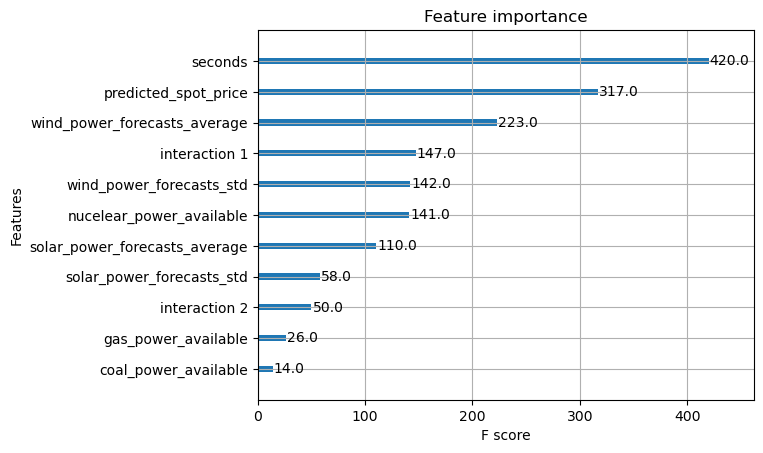

In [81]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(model0_final)
plt.show()


Maintenant que nous avons entrainer le modèle, nous pouvons prédire et imputer les valeurs manquantes par les prédictions obtenus:

In [83]:
ind0= X['load_forecast'].isnull()
predictions0= model0_final.predict(X.loc[ind0, :].drop(columns=['load_forecast', 'DELIVERY_START']))
X.loc[ind0,'load_forecast']= predictions0

On vérifie bien que la variable **load_forecast** ne contient plus de variables manquantes:

In [87]:
X.isnull().sum()/len(X)

DELIVERY_START                   0.000000
load_forecast                    0.000000
coal_power_available             0.000094
gas_power_available              0.000094
nucelear_power_available         0.000094
wind_power_forecasts_average     0.002263
solar_power_forecasts_average    0.002263
wind_power_forecasts_std         0.002263
solar_power_forecasts_std        0.002263
predicted_spot_price             0.825931
interaction 1                    0.002263
interaction 2                    0.002263
seconds                          0.000000
dtype: float64

On passe maintenant à l'imputation des valeurs.

#### 1.2.2 Imputation de predicted_spot_price

On a observé ci-dessus, une forte corrélation linéaire entre la variable **load_forecast** et la variable **predicted_spot_price**.
Dans un premier temps, on commence par ajuster à l'aide d'un xgboost en utilisant uniquement comme variable cible les valeurs réellement pour **predicted_spot_price**: Les variables explicatives correspondantes sont celles qui sont associés aux valeurs réellement observés pour **predicted_spot_price**.

In [89]:
ind1= X['predicted_spot_price'].notnull() # On utilise uniquement les valeurs observées 
X_1= X.loc[ind1, :].drop(columns=['DELIVERY_START','predicted_spot_price'])
y_1= X.loc[ind1, :]['predicted_spot_price']

In [91]:
X_1_train, X_1_test, y_1_train, y_1_test= train_test_split(X_1, y_1, train_size= 0.8, random_state= 7)

In [93]:
from xgboost import XGBRegressor

model1= XGBRegressor()
model1.fit(X_1_train, y_1_train)
print("Le score obtenu sur le train est: " +str(model1.score(X_1_train, y_1_train)))
print("Le score obtenu sur le test est: " +str(model1.score(X_1_test, y_1_test)))

Le score obtenu sur le train est: 0.9969025105617659
Le score obtenu sur le test est: 0.8877686119335201


On peut faire mieux ! On va passer à l'étape de la validation croisée.

**Validation-croisée**

In [113]:
model1= XGBRegressor()
param_grid1= {'n_estimators': [50,100,300,600,650], 'learning_rate': [0.01,0.1, 0.15, 0.2], 'max_depth': [1,2,3,5], 'min_child_weight': [1,2,3]}
grid_search1= GridSearchCV(model1, param_grid= param_grid1, cv= 6)

grid_search1.fit(X_1_train, y_1_train)

print("Les meilleurs hyperparamètres sont: "+ str(grid_search1.best_params_))
print("Le score de validation du meilleur modèle est: "+ str(grid_search1.best_score_))

model1_final= grid_search1.best_estimator_
model1_final.fit(X_1_train, y_1_train)


print("Le score sur le train est: ", str(model0_final.score(X_1_train, y_1_train)))
print("Le score sur le test est: ", str(model0_final.score(X_1_test, y_1_test)))




Les meilleurs hyperparamètres sont: {'learning_rate': 0.15, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 650}
Le score de validation du meilleur modèle est: 0.8742313225305409
Le score sur le train est:  0.9459206502038043
Le score sur le test est:  0.903991937876913


**Importance des variables**

<Figure size 640x480 with 0 Axes>

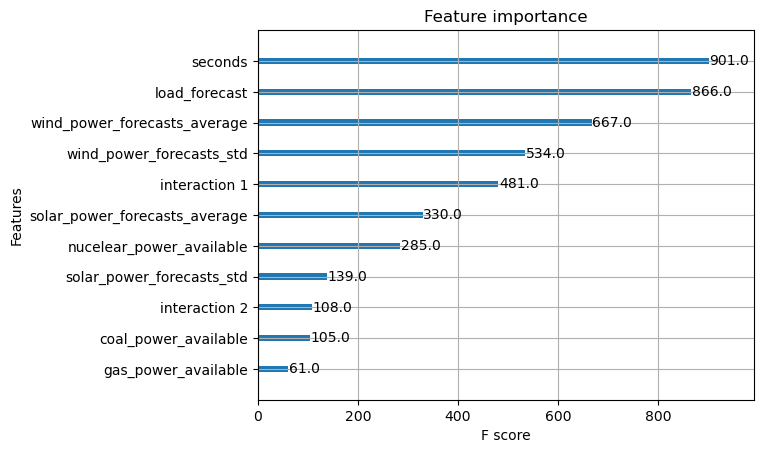

In [115]:
plt.figure()
plot_importance(model1_final)
plt.show()

#### 1.2.3 Imputation des autres variables et normalisation

In [117]:
ind1= X['predicted_spot_price'].isnull()
predictions1= model1_final.predict(X.loc[ind1, :].drop(columns=['predicted_spot_price', 'DELIVERY_START']))
X.loc[ind1,'predicted_spot_price']= predictions1
X= X.drop(columns= ['DELIVERY_START'])

In [119]:
X.isnull().sum()/len(X)

load_forecast                    0.000000
coal_power_available             0.000094
gas_power_available              0.000094
nucelear_power_available         0.000094
wind_power_forecasts_average     0.002263
solar_power_forecasts_average    0.002263
wind_power_forecasts_std         0.002263
solar_power_forecasts_std        0.002263
predicted_spot_price             0.000000
interaction 1                    0.002263
interaction 2                    0.002263
seconds                          0.000000
dtype: float64

In [121]:
from sklearn.impute import SimpleImputer

imputer= SimpleImputer(strategy= 'median')

X_final = imputer.fit_transform(X)

## 2. Recherche du meilleur modèle de prédiction XGBOOST

**Entrainement**

In [123]:
y_final= y['spot_id_delta']

In [125]:
X_train, X_test, y_train, y_test= train_test_split(X_final, y_final, train_size= 0.8, shuffle= True, random_state= 170)

In [191]:
X_train, X_test, y_train, y_test= train_test_split(X_final, y_final, train_size= 0.8, shuffle= True, random_state= 12) 
model= XGBRegressor(n_estimators= 317, learning_rate= 0.011, max_depth= 40, min_child_weight= 4)
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.8962735834174672
0.6132173881920022


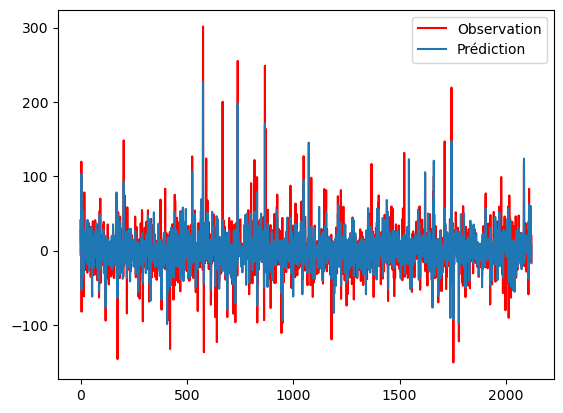

In [193]:
plt.figure()
plt.plot(np.arange(len(y_test)),y_test, color= 'red', label= 'Observation')
plt.plot(np.arange(len(y_test)),model.predict(X_test), label= 'Prédiction')
plt.legend()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

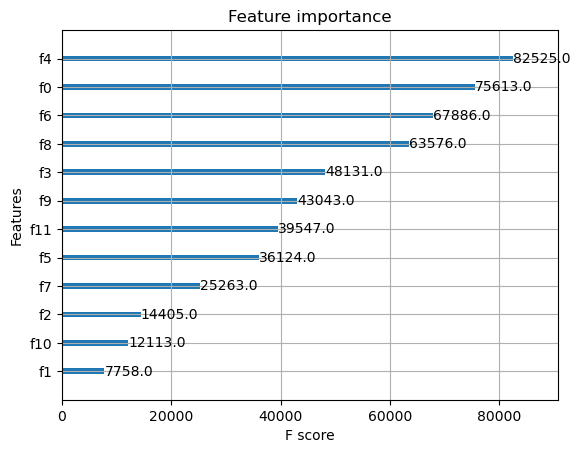

In [195]:
plot_importance(model)

**Prediction**

In [197]:
entree= pd.read_csv('/home/paul/Downloads/X_test.csv')
delivery_start= entree['DELIVERY_START']
entree['DELIVERY_START']= pd.to_datetime(entree['DELIVERY_START'], utc= True)
entree['interaction 1']= entree['wind_power_forecasts_average']*entree['wind_power_forecasts_std']
entree['interaction 2']= entree['solar_power_forecasts_average']*entree['solar_power_forecasts_std']
entree['seconds'] = (entree['DELIVERY_START'] - pd.Timestamp("2002-08-15 00:00:00+00")) // pd.Timedelta('1s')
entree= entree.drop(columns=['DELIVERY_START'])


print(entree.isnull().sum()/len(entree))

load_forecast                    0.000000
coal_power_available             0.000000
gas_power_available              0.000000
nucelear_power_available         0.000000
wind_power_forecasts_average     0.000000
solar_power_forecasts_average    0.004856
wind_power_forecasts_std         0.000000
solar_power_forecasts_std        0.004856
predicted_spot_price             0.310805
interaction 1                    0.000000
interaction 2                    0.004856
seconds                          0.000000
dtype: float64


Pour les données à prédire, il y a toujours le problème de valeurs manquantes.
Nous avons tout d'abord les effectuer les memes transformations sur la variable d'entrée que sur les variables d'entrainement ensuite , nous allons imputer à l'aide des précédents modèles d'imputation: Ajout  des variables d'interaction, conversion de la variable **DELIVERY_START** secondes écoulée depuis le ...
Comme stratégie, nous allons prédire les valeurs manquantes de la variable **predicted_spot_price** à l'aide des autres variables explicatives(meme si elle contiennent quelques valeurs manquantes,le xgboost étant peu sensible aux valeurs manquantes).
Enfin, nous allons faire une simple imputation pour les autres valeurs manquantes en les remplacant par la mediane.

In [199]:
ind_= entree['predicted_spot_price'].isnull()
predictions2= model1_final.predict(entree.loc[ind_, :].drop(columns= ['predicted_spot_price']))
entree.loc[ind_, 'predicted_spot_price']= predictions2

In [201]:
entree.isnull().sum()

load_forecast                     0
coal_power_available              0
gas_power_available               0
nucelear_power_available          0
wind_power_forecasts_average      0
solar_power_forecasts_average    24
wind_power_forecasts_std          0
solar_power_forecasts_std        24
predicted_spot_price              0
interaction 1                     0
interaction 2                    24
seconds                           0
dtype: int64

On a bel et bien imputé les valeurs manquantes de la variable **predicted_spot_price**.
Ensuite pour les autres valeurs manquantes, on remplace par la médiane.

In [203]:
imputer2= SimpleImputer(strategy= 'median')
entree_final= imputer2.fit_transform(entree)

Ensuite, on peut passer à la prédiction.

In [205]:
prediction= model.predict(entree_final)

In [209]:
data= {'DELIVERY_START': delivery_start , 'spot_id_delta': prediction}
df_soumettre= pd.DataFrame(data= data, columns=['DELIVERY_START','spot_id_delta'])
df_soumettre.to_csv('resultat2', index= False)

In [207]:
prediction.mean()

2.0960224